# MRI based brain tumor IDH classification with MONAI (3D multiparametric MRI)

This tutorial shows how to construct a training workflow of binary classification task.  
And it contains below features:
1. Transforms for Monai, and TorchIO dictionary format data.
2. Define a new transform according to TorchIO, and MONAI transform API.
3. Load Nifti image with metadata, load a list of images and stack them.
5. 3D Densenet model, cross entropy loss function for IDH classification task.
6. Deterministic training for reproducibility.

The Brain tumor dataset can be downloaded from 
https://ipp.cbica.upenn.edu/ and  http://medicaldecathlon.com/.  

Target: IDH classification based on whole brain, tumour core, whole tumor, and enhancing tumor from MRI 
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
training: 585 3D MRI\
validation: 87 3D MRI\
testing: Not revealed

Source: BRATS 2021 datasets.  
Challenge: RSNA-MICCAI Brain Tumor Radiogenomic Classification

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right). (Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))  
![image](https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/42/7283692/6975210/6975210-fig-3-source-large.gif)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
2. the tumor core (red) visible in T2 (Fig.B).
3. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
4. The segmentations are used to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import sys
import gc
import logging
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy import ndimage
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import DynUNet, EfficientNetBN, DenseNet121, SegResNet, SegResNetVAE
from monai.data import CacheDataset, Dataset, DataLoader, ThreadDataLoader
from torch.utils.data import WeightedRandomSampler

import monai
from monai.transforms import (
    Activations,
    AsDiscrete,
    CastToTyped,
    Compose, 
    CropForegroundd,
    ResizeWithPadOrCrop,
    ResizeWithPadOrCropd,
    Spacingd,
    RandRotate90d,
    Resized,
    EnsureChannelFirstd, 
    Orientationd,
    LoadImaged,
    NormalizeIntensity,
    HistogramNormalize,
    NormalizeIntensityd,
    RandCropByPosNegLabeld,
    RandCropByLabelClassesd,
    RandAffined,
    RandFlipd,
    Flipd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandGibbsNoised,
    RandStdShiftIntensityd,
    RandScaleIntensityd,
    RandZoomd, 
    SpatialCrop, 
    SpatialPadd, 
    MapTransform,
    CastToType,
    ToTensord,
    AddChanneld,
    MapTransform,
    Orientationd,
    ScaleIntensityd,
    ScaleIntensity,
    ScaleIntensityRangePercentilesd,
    ScaleIntensityRange,
    RandShiftIntensityd,
    RandAdjustContrastd,
    AdjustContrastd,
    Rotated,
    ToNumpyd,
    ToDeviced,
    EnsureType,
    EnsureTyped,
    DataStatsd,
)

from monai.config import KeysCollection
from monai.transforms.compose import MapTransform, Randomizable
from collections.abc import Iterable
from typing import Any, Dict, Hashable, Mapping, Optional, Sequence, Tuple, Union
from monai.utils import set_determinism
from monai.utils import (
    ensure_tuple,
    ensure_tuple_rep,
    ensure_tuple_size,
)

from monai.optimizers import LearningRateFinder

from monai.transforms.compose import MapTransform
from monai.transforms.utils import generate_spatial_bounding_box
from skimage.transform import resize
from monai.losses import DiceCELoss, DiceLoss
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference


from monai.metrics import DiceMetric, ROCAUCMetric
from monai.data import decollate_batch
import glob
import monai
from monai.metrics import compute_meandice
import random
import pickle
from collections import OrderedDict
from typing import Sequence, Optional
import ipywidgets as widgets
from itertools import compress
import SimpleITK as sitk
import torchio as tio

import sklearn
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, recall_score, \
accuracy_score, precision_score, f1_score, make_scorer 

from monai.utils import ensure_tuple_rep
from monai.networks.layers.factories import Conv, Dropout, Norm, Pool
import matplotlib.pyplot as plt
from ranger21 import Ranger21

### monai and ignite based imports
import logging
from ignite.engine import Engine, Events
from ignite.contrib.handlers import FastaiLRFinder, ProgressBar
from ignite.engine import (
    Events,
    _prepare_batch,
    create_supervised_evaluator,
    create_supervised_trainer,
)
from ignite.handlers import EarlyStopping, ModelCheckpoint

from itkwidgets import view
import random
monai.config.print_config()
#from sliding_window_inference_classes import sliding_window_inference_classes

MONAI version: 0.8.0
Numpy version: 1.20.2
Pytorch version: 1.9.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.1
tqdm version: 4.61.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.2.4
einops version: 0.3.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
MAX_THREADS =2
sitk.ProcessObject.SetGlobalDefaultNumberOfThreads(MAX_THREADS)

In [3]:
seeds = 40961024
set_determinism(seed=seeds)
##np.random.seed(seeds) np random seed does not work here
!nvidia-smi

Sat Jun 11 17:19:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   46C    P0    44W / 300W |    108MiB / 32505MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [4]:
#patch_size = (128, 128, 128)

spacing = (1.0, 1.0, 1.0)
os.environ["CUDA_VISIBLE_DEVICES"] ="2"
device = torch.device('cuda:0')
deviceName = 'cuda:0'

In [5]:
pd.set_option('display.max_colwidth', None)
data_rpath = '/home/mmiv-ml/data'


In [6]:
BraTS20SubjectsIDHWithMetaDF  = pd.read_csv('assets/BraTS20SubjectsIDHWithMetaDF.csv')
BraTS20SubjectsIDHWithMetaDF

,BraTS2020,t1wPath,t1cwPath,t2wPath,flairPath,segPath,t1w_BrainmaskPath,IDH_value,BraTS2021,BraTS2019,...,ET_CoordX,ET_CoordY,ET_CoordZ,ED_CoordX,ED_CoordY,ED_CoordZ,NEC_CoordX,NEC_CoordY,NEC_CoordZ,is_merged_3
0,BraTS20_Training_274,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_274/BraTS20_Training_274_BrainROI.nii.gz,0,BraTS2021_01479,BraTS19_TCIA09_141_1,...,102.788589,97.639325,94.684363,118.038612,106.882949,88.290266,106.202255,91.666134,96.335216,both
1,BraTS20_Training_293,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_293/BraTS20_Training_293_BrainROI.nii.gz,0,BraTS2021_01498,BraTS19_TCIA10_410_1,...,101.672477,85.079209,81.828045,96.746334,107.863478,83.794617,99.950014,88.945683,89.526921,both
2,BraTS20_Training_190,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_190/BraTS20_Training_190_BrainROI.nii.gz,1,BraTS2021_01300,BraTS19_TCIA02_226_1,...,161.133893,117.501382,72.152114,158.558518,124.733076,69.336469,161.917178,114.233129,78.978528,both
3,BraTS20_Training_298,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_298/BraTS20_Training_298_BrainROI.nii.gz,0,BraTS2021_01503,BraTS19_TCIA10_276_1,...,110.542553,73.074468,70.808511,107.090113,82.676138,76.029439,105.099771,65.077985,76.992437,both
4,BraTS20_Training_334,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_334/BraTS20_Training_334_BrainROI.nii.gz,0,BraTS2021_01665,BraTS19_TCIA13_624_

## Cearing a list of dictionaries in order to feed into Monai's Dataset
Keys:
- ***image:*** T1, T1c, T2, and flair image
- ***label:*** Segmented mask GT
- ***brain_mask:*** Whole brain area (brain area=1 and Non brain area=0)
- ***IDH_value:*** IDH class corresponding to the subject/images

In [7]:
train_files = [{'image': (image_nameT1, image_nameT1ce, image_nameT2, image_nameFl), 'label': label_name, 'brain_mask':brain_mask, 'IDH_label': np.array(IDH_label_name)} 
               for image_nameT1,image_nameT1ce, image_nameT2, image_nameFl, label_name, brain_mask, IDH_label_name 
               in zip(BraTS20SubjectsIDHWithMetaDF['t1wPath'], BraTS20SubjectsIDHWithMetaDF['t1cwPath'], BraTS20SubjectsIDHWithMetaDF['t2wPath'], BraTS20SubjectsIDHWithMetaDF['flairPath'],\
                     BraTS20SubjectsIDHWithMetaDF['segPath'], BraTS20SubjectsIDHWithMetaDF['t1w_BrainmaskPath'], BraTS20SubjectsIDHWithMetaDF['IDH_value'])]

# train_files_image = [(image_nameT1, image_nameT1ce, image_nameT2, image_nameFl) 
#                      for image_nameT1,image_nameT1ce, image_nameT2, image_nameFl 
#                      in zip(dfTrainLbl['t1wPath'], dfTrainLbl['t1cwPath'], dfTrainLbl['T2wPath'], dfTrainLbl['FlairPath'])]
# train_files_label = dfTrainLbl['segPath'].tolist()
# train_files_brain_mask = dfTrainLbl['brain_maskPath'].tolist()
# train_files_IDH_label = dfTrainLbl['IDH_value'].values.ravel().tolist()


## Creating 5 splits for cross validaion (5 cross validaion)

In [8]:
n_splits = 3
#train_index = np.linspace(0, train_features.shape[0]-1, num = train_features.shape[0], dtype = np.uint16, endpoint=True)
#partition_data = monai.data.utils.partition_dataset_classes(train_index, train_labels.values.ravel().tolist(), shuffle=True, num_partitions=n_splits) 
#partition_data = monai.data.utils.partition_dataset_classes(train_files, dfTrainLbl['IDH_value'].values.ravel().tolist(), shuffle=True, num_partitions=n_splits)
partition_data = monai.data.partition_dataset_classes(train_files, BraTS20SubjectsIDHWithMetaDF['IDH_value'].values.ravel().tolist(), shuffle=True, num_partitions=n_splits)
print(len(partition_data), len(partition_data[0]), len(partition_data[1]), len(partition_data[2]))


# val_folds = {}
# train_folds = {}
# flds = np.linspace(0, n_splits, num=n_splits, dtype = np.int8)
# for cfold in range(n_splits):
#     not_cfold = np.delete(flds, cfold)
#     val_folds[cfold] = partition_data[cfold]
# #     train_folds[cfold] = 
# # sub_flds = flds[..., ~0]   
# # sub_flds

val_folds = {}
train_folds = {}
flds = np.linspace(0, n_splits, num=n_splits, dtype = np.uint8)
for cfold in range(n_splits):
    #val_folds[f"fold{cfold}"] = train_features.values[partition_data[cfold],:]
    #train_folds[f"fold{cfold}"] = np.delete(train_features.values, partition_data[cfold], axis=0)
    #not_cfold = np.delete(flds, cfold)
    
    val_folds[f"fold{cfold}"] = partition_data[cfold]
    val_folds[f"fold{cfold}_IDH_label"] = [adct['IDH_label'].item() for adct in partition_data[cfold]]
    train_folds_masks = [1]*n_splits
    train_folds_masks[cfold] = 0
    partition_data_non_cfold = list()
    for aDctLstitem in compress(partition_data, train_folds_masks):
        partition_data_non_cfold.extend(aDctLstitem)
        
        
    train_folds[f"fold{cfold}"] = partition_data_non_cfold
    train_folds[f"fold{cfold}_IDH_label"] = [adct['IDH_label'].item() for adct in partition_data_non_cfold]

for i in range(n_splits):
    print('val: ', len(val_folds[f'fold{i}']), 'train: ', len(train_folds[f'fold{i}']), '\n')

3 45 45 45
val:  45 train:  90 

val:  45 train:  90 

val:  45 train:  90 



In [9]:

for i_cv in range(n_splits):
    print('Training classes\n')
    print(np.unique([train_folds[f'fold{i_cv}'][i]['IDH_label'].item() for i in range(len(train_folds[f'fold{i_cv}']))], return_counts = True))
    print('\nValidation classes\n')
    print(np.unique([val_folds[f'fold{i_cv}'][i]['IDH_label'].item() for i in range(len(val_folds[f'fold{i_cv}']))], return_counts = True))
    print('#'*4, '\n\n')

Training classes

(array([0, 1]), array([38, 52]))

Validation classes

(array([0, 1]), array([19, 26]))
#### 


Training classes

(array([0, 1]), array([38, 52]))

Validation classes

(array([0, 1]), array([19, 26]))
#### 


Training classes

(array([0, 1]), array([38, 52]))

Validation classes

(array([0, 1]), array([19, 26]))
#### 




***HistogramStandardization***

Implementing histogram standardization from [torchIO](https://github.com/fepegar/torchio) library

Bases: [torchio.transforms.preprocessing.intensity.normalization_transform.NormalizationTransform](https://torchio.readthedocs.io/transforms/preprocessing.html#torchio.transforms.preprocessing.intensity.NormalizationTransform)

Perform histogram standardization of intensity values.

Implementation of [New variants of a method of MRI scale standardization](https://ieeexplore.ieee.org/document/836373).

We can visit in [torchio.transforms.HistogramStandardization.train()]((https://torchio.readthedocs.io/transforms/preprocessing.html#torchio.transforms.HistogramStandardization.train)) for more details.

PARAMETERS
landmarks – Dictionary (or path to a PyTorch file with .pt or .pth extension in which a dictionary has been saved) whose keys are image names in the subject and values are NumPy arrays or paths to NumPy arrays defining the landmarks after training with [torchio.transforms.HistogramStandardization.train()](https://torchio.readthedocs.io/transforms/preprocessing.html#torchio.transforms.HistogramStandardization.train).

Here, ***save_dir*** is a path where the trained histogram files for four channels (T1w, T1cw, T2w, and Flair), and trained model's weights will be saved

In [97]:
# file_prefix = 'ConvEffNet_Brats21_1SplitV0'
# savedirname = 'ConvEffNet_Brats21'
# save_dir = os.path.join('/raid/brats2021/pthBraTS2021Radiogenomics', savedirname)
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# train_images20T1 = dfTrainLbl['t1wPath'].values
# train_images20T1ce = dfTrainLbl['t1cwPath'].values
# train_images20T2 = dfTrainLbl['T2wPath'].values
# train_images20Flair = dfTrainLbl['FlairPath'].values

# hiseq_t1npyfile = os.path.join(save_dir, f"histeq_t1w_{file_prefix}.npy")
# t1w_landmarks = (hiseq_t1npyfile if os.path.isfile(hiseq_t1npyfile) else \
#                  tio.HistogramStandardization.train(train_images20T1, output_path = hiseq_t1npyfile))
# # #torch.save(t1w_landmarks, hiseq_t1npyfile)

# hiseq_t1cnpyfile =  os.path.join(save_dir, f"histeq_t1cw_{file_prefix}.npy")
# t1cw_landmarks = (hiseq_t1cnpyfile if os.path.isfile(hiseq_t1cnpyfile) else \
#                   tio.HistogramStandardization.train(train_images20T1ce, output_path = hiseq_t1cnpyfile))
# #torch.save(t1cw_landmarks, hiseq_t1cnpyfile)


# hiseq_t2npyfile = os.path.join(save_dir, f"histeq_t2w_{file_prefix}.npy")
# t2w_landmarks = (hiseq_t2npyfile if os.path.isfile(hiseq_t2npyfile) else \
#                  tio.HistogramStandardization.train(train_images20T2, output_path = hiseq_t2npyfile))
# #torch.save(t2w_landmarks, hiseq_t2npyfile)

# hiseq_flairnpyfile = os.path.join(save_dir, f"histeq_flair_{file_prefix}.npy")
# flair_landmarks = (hiseq_flairnpyfile if os.path.isfile(hiseq_flairnpyfile) else \
#                    tio.HistogramStandardization.train(train_images20Flair, output_path = hiseq_flairnpyfile))
# #torch.save(flair_landmarks, hiseq_flairnpyfile)

file_prefix = 'DynUNet_Brats20_3CV_4Chnls1PatchSWIRngr21_2nclass'
savedirname = 'DynUNetVariants_Brats20'
save_dir = os.path.join('/raid/brats2021/pthBraTS2020_IDHGenomics', savedirname)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)



Extracting epoch, dice scores (for whole tumor (WT), tumor core (TC), and enhancing tumor (ET)), and validation loss 

In [98]:
df_Records = pd.read_csv(os.path.join(save_dir, 'Logs_DynUNet_Brats20_3CV_4Chnls1PatchSWIRngr21_2nclass.txt'), delimiter='\n', header = None)
df_Records = df_Records.iloc[0:1500,]
display(df_Records)

,0
0,"current fold: 0 current epoch: 1 dice_score: 0.0396 acc_metric: 0.5000 accuracy: 0.4222, f1score: 0.4222 epoch 1 average training loss: 2.8607 average validation loss: 1.6241"
1,"current fold: 0 current epoch: 2 dice_score: 0.0441 acc_metric: 0.5000 accuracy: 0.4222, f1score: 0.4222 epoch 2 average training loss: 2.8478 average validation loss: 1.6160"
2,"current fold: 0 current epoch: 3 dice_score: 0.0489 acc_metric: 0.5000 accuracy: 0.4222, f1score: 0.4222 epoch 3 average training loss: 2.8162 average validation loss: 1.6068"
3,"current fold: 0 current epoch: 4 dice_score: 0.0586 acc_metric: 0.5000 accuracy: 0.4222, f1score: 0.4222 epoch 4 average training loss: 2.8009 average validation loss: 1.5974"
4,"current fold: 0 current epoch: 5 dice_score: 0.0670 acc_metric: 0.5000 accuracy: 0.4222, f1score: 0.4222 epoch 5 average training loss: 2.7625 average validation loss: 1.5854"
...,...
1495,"current fold: 2 current epoch: 496 dice_score: 0.8582 acc_metric: 0.7024 accuracy: 0.6889, f1score: 0.6889 epoch 496 average training loss: 0.0761 average validation loss: 0.7344"
1496,"current fold: 2 current epoch: 497 dice_score: 0.8590 acc_metric: 0.7024 accuracy: 0.6889, f1score: 0.6889 epoch 497 average training loss: 0.0789 average validation loss: 0.7324"
1497,"current fold: 2 current epoch: 498 dice_score: 0.8608 acc_metric: 0.6953 accuracy: 0.6889, f1score: 0.6889 epoch 498 average training loss: 0.1446 average validation loss: 0.7298"
1498,"current fold: 2 current epoch: 499 dice_score: 0.8572 acc_metric: 0.7287 accuracy: 0.7111, f1score: 0.7111 epoch 499 average training loss: 0.1464 average validation loss: 0.7328"


In [99]:
# df_Records = df_Records.loc[df_Records['epoch 1/1000'].str.contains('current epoch:')]
# df_Records = df_Records.rename(columns = {'epoch 1/1000':'EpochRecords'})
df_Records = df_Records[0].str.split(expand=True)
df_Records

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,current,fold:,0,current,epoch:,1,dice_score:,0.0396,acc_metric:,0.5000,...,epoch,1,average,training,loss:,2.8607,average,validation,loss:,1.6241
1,current,fold:,0,current,epoch:,2,dice_score:,0.0441,acc_metric:,0.5000,...,epoch,2,average,training,loss:,2.8478,average,validation,loss:,1.6160
2,current,fold:,0,current,epoch:,3,dice_score:,0.0489,acc_metric:,0.5000,...,epoch,3,average,training,loss:,2.8162,average,validation,loss:,1.6068
3,current,fold:,0,current,epoch:,4,dice_score:,0.0586,acc_metric:,0.5000,...,epoch,4,average,training,loss:,2.8009,average,validation,loss:,1.5974
4,current,fold:,0,current,epoch:,5,dice_score:,0.0670,acc_metric:,0.5000,...,epoch,5,average,training,loss:,2.7625,average,validation,loss:,1.5854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,current,fold:,2,current,epoch:,496,dice_score:,0.8582,acc_metric:,0.7024,...,epoch,496,average,training,loss:,0.0761,average,validation,loss:,0.7344
1496,current,fold:,2,current,epoch:,497,dice_score:,0.8590,acc_metric:,0.7024,...,epoch,497,average,training,loss:,0.0789,average,validation,loss:,0.7324
1497,current,fold:,2,current,epoch:,498,dice_score:,0.8608,acc_metric:,0.6953,...,epoch,498,average,training,loss:,0.1446,average,validation,loss:,0.7298
1498,current,fold:,2,current,epoch:,499,dice_score:,0.8572,acc_metric:,0.7287,...,epoch,499,average,training,loss:,0.1464,average,validation,loss:,0.7328


In [100]:
df_Records.iloc[0,:]

0         current
1           fold:
2               0
3         current
4          epoch:
5               1
6     dice_score:
7          0.0396
8     acc_metric:
9          0.5000
10      accuracy:
11        0.4222,
12       f1score:
13         0.4222
14          epoch
15              1
16        average
17       training
18          loss:
19         2.8607
20        average
21     validation
22          loss:
23         1.6241
Name: 0, dtype: object

In [101]:
df_Records = df_Records.iloc[:,[2, 5, 7, 9, 11, 13, 19, 23]]

df_Records = df_Records.rename(columns = {2:'Fold', 5:'Epoch', 7:'Mean dice', 9:'AUC score', 11: 'Accuracy', 13:'F1 score', 19: 'Training loss', 23: 'Validation loss'})
df_Records['Accuracy'] = df_Records['Accuracy'].str.replace(',', '')
df_Records = df_Records.astype(str) 
df_Records = df_Records.apply(pd.to_numeric, errors='ignore')
df_Records.sort_values(by = ['AUC score'])
display(df_Records)

,Fold,Epoch,Mean dice,AUC score,Accuracy,F1 score,Training loss,Validation loss
0,0,1,0.0396,0.5000,0.4222,0.4222,2.8607,1.6241
1,0,2,0.0441,0.5000,0.4222,0.4222,2.8478,1.6160
2,0,3,0.0489,0.5000,0.4222,0.4222,2.8162,1.6068
3,0,4,0.0586,0.5000,0.4222,0.4222,2.8009,1.5974
4,0,5,0.0670,0.5000,0.4222,0.4222,2.7625,1.5854
...,...,...,...,...,...,...,...,...
1495,2,496,0.8582,0.7024,0.6889,0.6889,0.0761,0.7344
1496,2,497,0.8590,0.7024,0.6889,0.6889,0.0789,0.7324
1497,2,498,0.8608,0.6953,0.6889,0.6889,0.1446,0.7298
1498,2,499,0.8572,0.7287,0.7111,0.7111,0.1464,0.7328


### Plots for loss/dice score versus number of epoch 

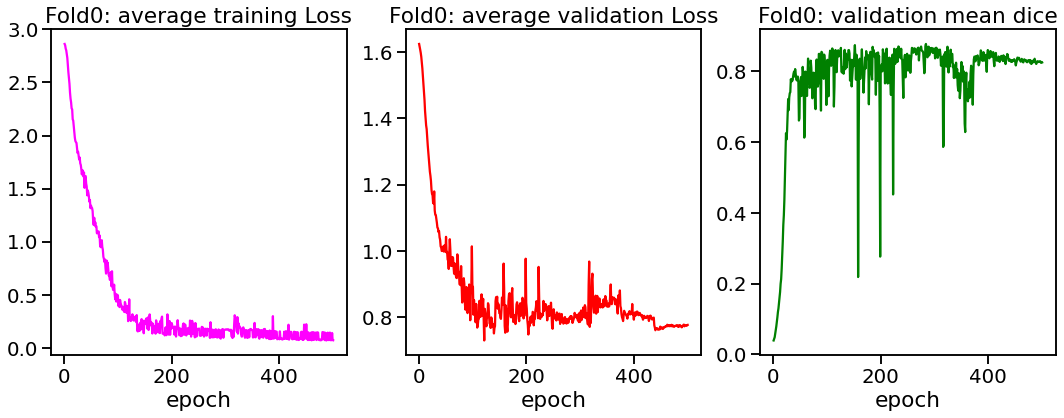

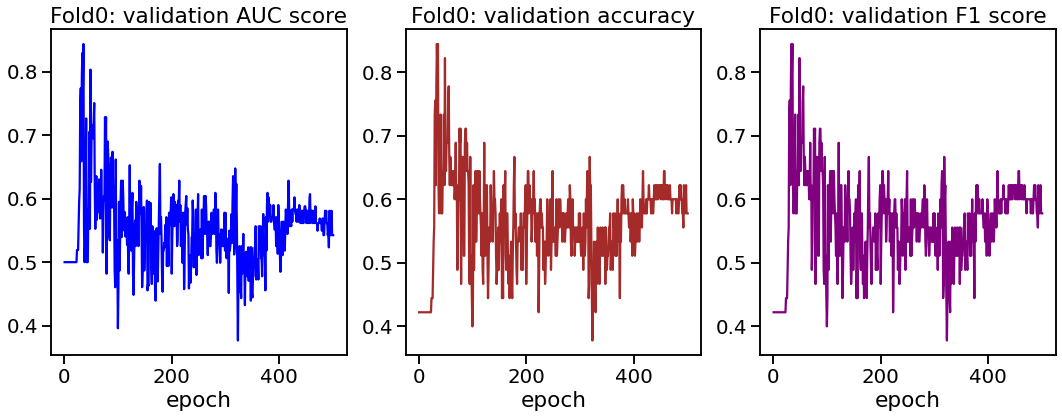

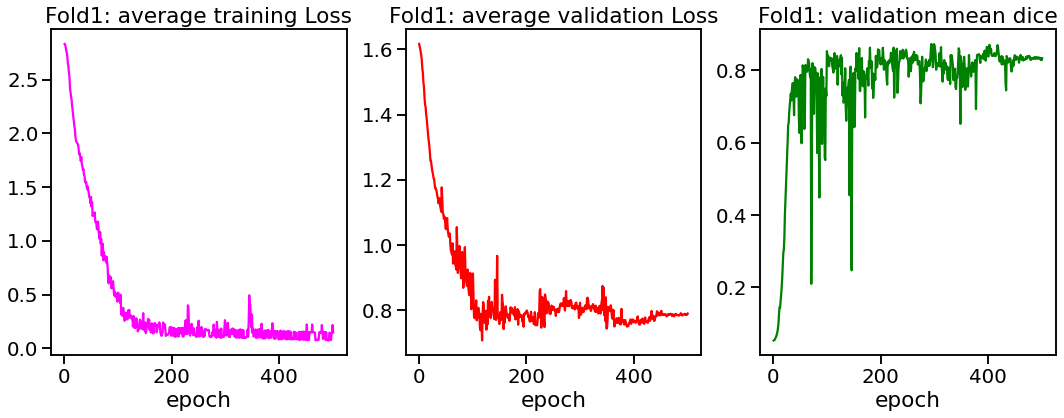

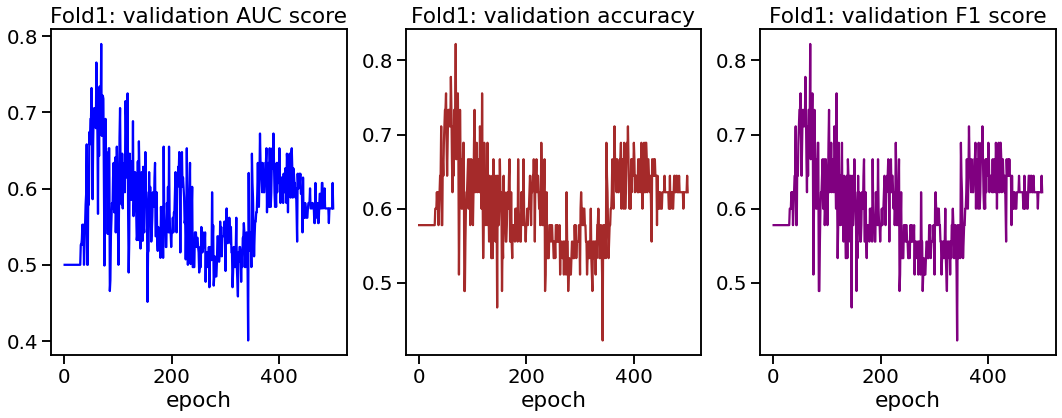

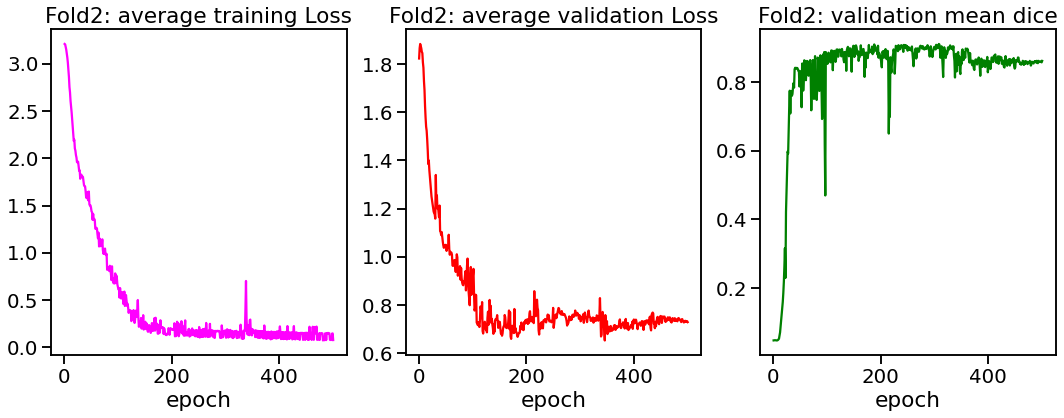

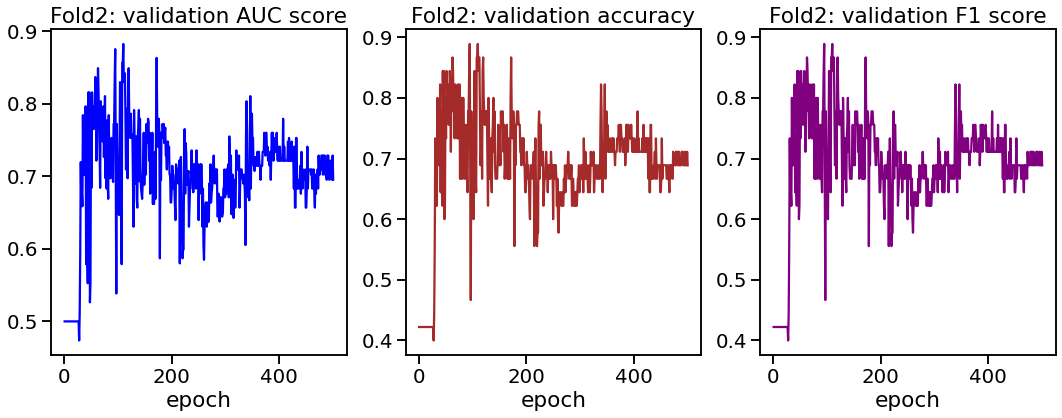

In [126]:
import seaborn as sns
sns.set_context(context='talk', font_scale=1.2)
for cfold in [0, 1, 2]:

    df_RecordsAFold = df_Records.loc[df_Records['Fold']==cfold]

    
    plt.figure('train', (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f'Fold{cfold}: average training Loss')
    x = [i+1 for i in range(len(df_RecordsAFold['Epoch'].values))]
    y = df_RecordsAFold['Training loss'].values
    plt.xlabel('epoch')
    plt.plot(x, y, color='magenta')
    
    
    plt.figure('train', (12, 6))
    plt.subplot(1, 3, 2)
    plt.title(f'Fold{cfold}: average validation Loss')
    x = [i+1 for i in range(len(df_RecordsAFold['Epoch'].values))]
    y = df_RecordsAFold['Validation loss'].values
    plt.xlabel('epoch')
    plt.plot(x, y, color='red')

    plt.subplot(1, 3, 3)
    plt.title(f'Fold{cfold}: validation mean dice')
    val_interval = 1
    x = [val_interval * (i + 1) for i in range(len(df_RecordsAFold['Mean dice'].values))]
    y = df_RecordsAFold['Mean dice'].values
    plt.xlabel('epoch')
    plt.plot(x, y, color='green')
    plt.show()

    plt.figure('train', (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f'Fold{cfold}: validation AUC score')
    x = [val_interval * (i + 1) for i in range(len(df_RecordsAFold['AUC score'].values))]
    y = df_RecordsAFold['AUC score'].values
    plt.xlabel('epoch')
    plt.plot(x, y, color='blue')


    plt.subplot(1, 3, 2)
    plt.title(f'Fold{cfold}: validation accuracy')
    x = [val_interval * (i + 1) for i in range(len(df_RecordsAFold['Accuracy'].values))]
    y = df_RecordsAFold['Accuracy'].values
    plt.xlabel('epoch')
    plt.plot(x, y, color='brown')

    plt.subplot(1, 3, 3)
    plt.title(f'Fold{cfold}: validation F1 score')
    x = [val_interval * (i + 1) for i in range(len(df_RecordsAFold['F1 score'].values))]
    y = df_RecordsAFold['F1 score'].values
    plt.xlabel('epoch')
    plt.plot(x, y, color='purple')
    plt.show()
    #print('Another fold #######\n\n\n')

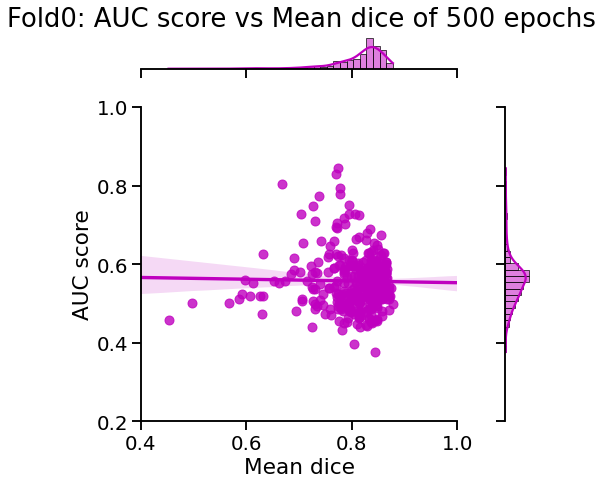

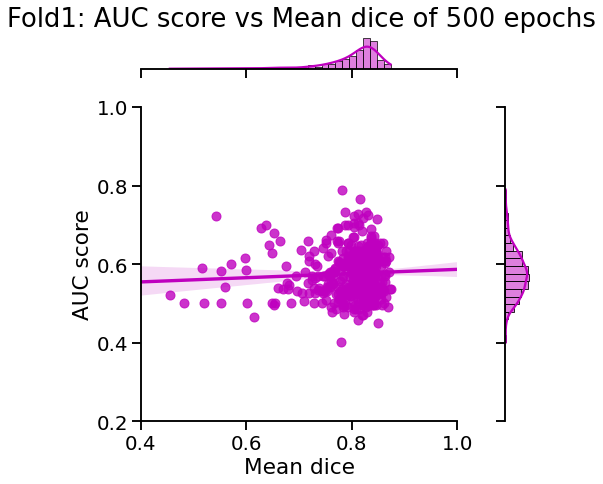

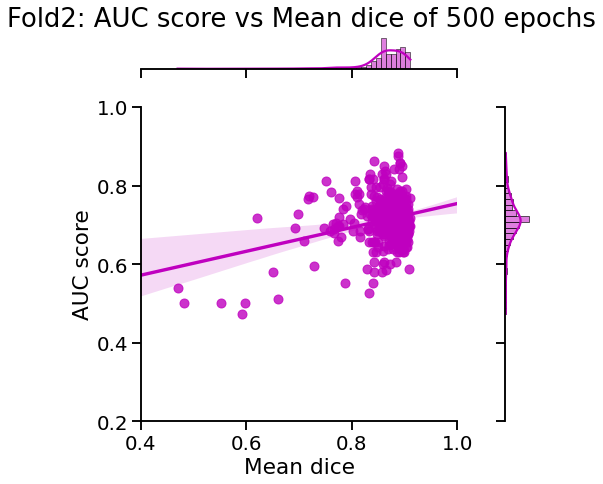

In [103]:
import seaborn as sns
sns.set_context(context='talk', font_scale=1.2)
for cfold in [0, 1, 2]:

    df_RecordsAFold = df_Records.loc[df_Records['Fold']==cfold]
    #df_RecordsAFold = df_RecordsAFold.loc[(df_RecordsAFold['Training loss']<0.8) & (df_RecordsAFold['Validation loss']<0.8)]
    df_RecordsAFold = df_RecordsAFold.loc[df_RecordsAFold['Mean dice']>0.45]
    
    
    # g = sns.lmplot(x="Mean dice", y="AUC score", data=df_RecordsAFold)
    g = sns.jointplot(x="Mean dice", y="AUC score", data=df_RecordsAFold,
                  kind="reg", truncate=False,
                  xlim=(0.4, 1.0), ylim=(0.2, 1.0),
                  color="m", height=7)
    g.fig.tight_layout()
    g.fig.suptitle(f'Fold{cfold}: AUC score vs Mean dice of 500 epochs')
    g.fig.subplots_adjust(top=0.92) # Reduce plot to make room 

In [119]:
df_RecordsAFold = df_Records.loc[df_Records['Fold']==0]

In [120]:
#df_RecordsAFold.nlargest(n=15, columns=['AUC score','Mean dice'])
df_RecordsAFold.nlargest(n=15, columns=['AUC score','Mean dice'])

,Fold,Epoch,Mean dice,AUC score,Accuracy,F1 score,Training loss,Validation loss
0,0,1,0.0396,0.5,0.4222,0.4222,2.8607,1.6241
1,0,2,0.0441,0.5,0.4222,0.4222,2.8478,1.6160
2,0,3,0.0489,0.5,0.4222,0.4222,2.8162,1.6068
3,0,4,0.0586,0.5,0.4222,0.4222,2.8009,1.5974
4,0,5,0.0670,0.5,0.4222,0.4222,2.7625,1.5854
5,0,6,0.0795,0.5,0.4222,0.4222,2.7298,1.5693
6,0,7,0.0918,0.5,0.4222,0.4222,2.6621,1.5506
7,0,8,0.1052,0.5,0.4222,0.4222,2.5935,1.5279
8,0,9,0.1200,0.5,0.4222,0.4222,2.5444,1.5027
9,0,10,0.1303,0.5,0.4222,0.4222,2.4859,1.4836


### Top-5 auc vs corresponding mean dice

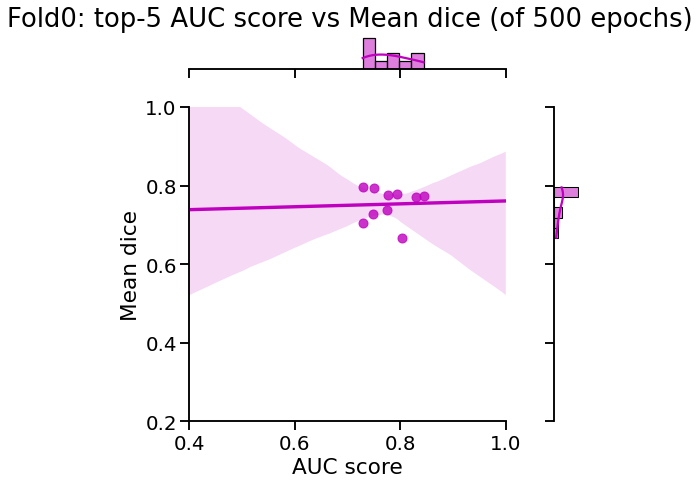

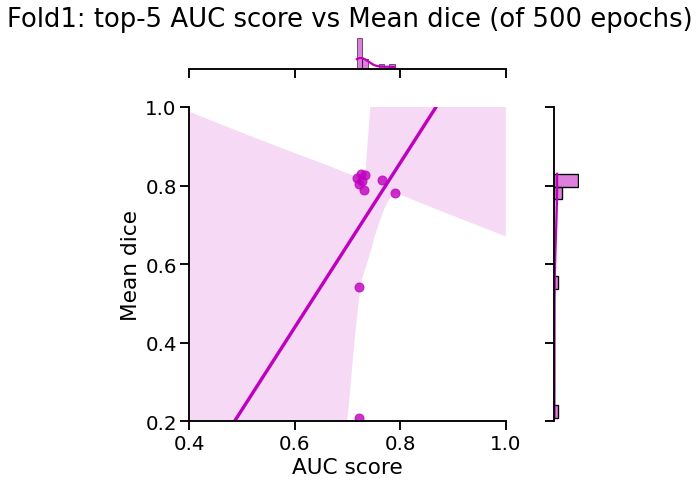

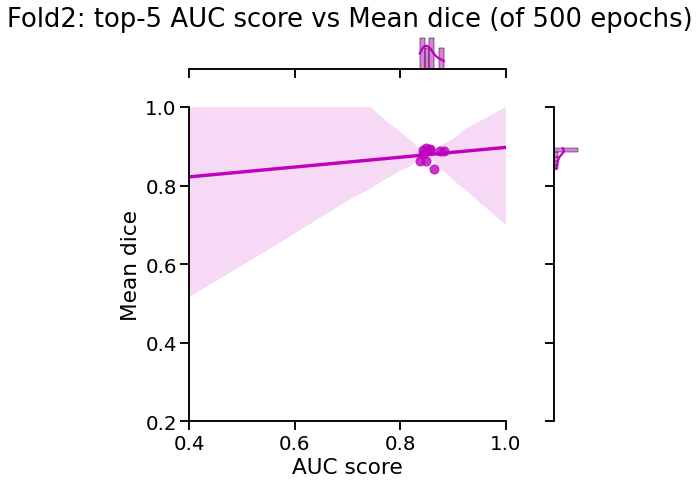

In [109]:
import seaborn as sns
sns.set_context(context='talk', font_scale=1.2)
for cfold in [0, 1, 2]:

    df_RecordsAFold = df_Records.loc[df_Records['Fold']==cfold]
    #df_RecordsAFold = df_RecordsAFold.loc[(df_RecordsAFold['Training loss']<0.8) & (df_RecordsAFold['Validation loss']<0.8)]
    df_RecordsAFold = df_RecordsAFold.nlargest(n=10, columns=['AUC score','Mean dice'])
    
    # g = sns.lmplot(x="Mean dice", y="AUC score", data=df_RecordsAFold)
    g = sns.jointplot(x="AUC score", y="Mean dice", data=df_RecordsAFold,
                  kind="reg", truncate=False,
                  xlim=(0.4, 1.0), ylim=(0.2, 1.0),
                  color="m", height=7)
    g.fig.tight_layout()
    g.fig.suptitle(f'Fold{cfold}: top-5 AUC score vs Mean dice (of 500 epochs)')
    g.fig.subplots_adjust(top=0.92) # Reduce plot to make room 

### Top-5 mean dice score vs corresponding AUC score

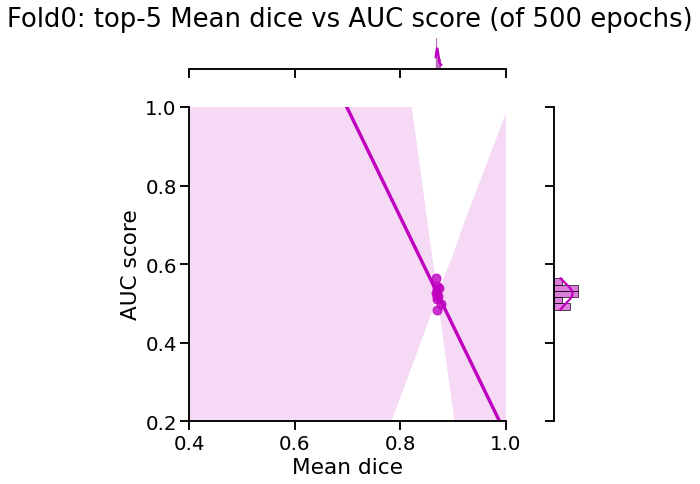

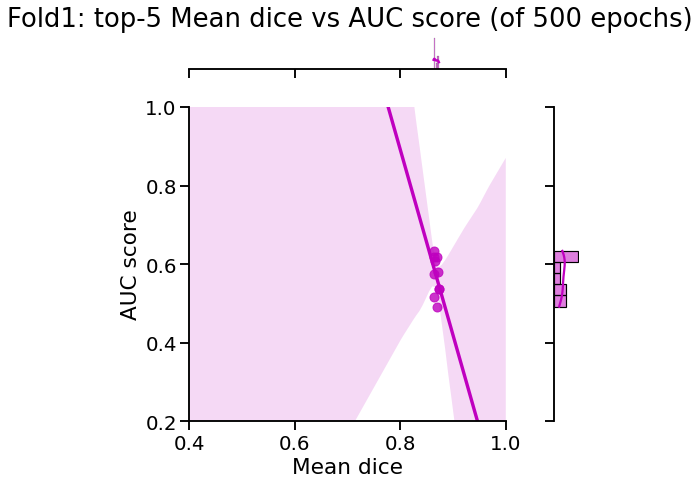

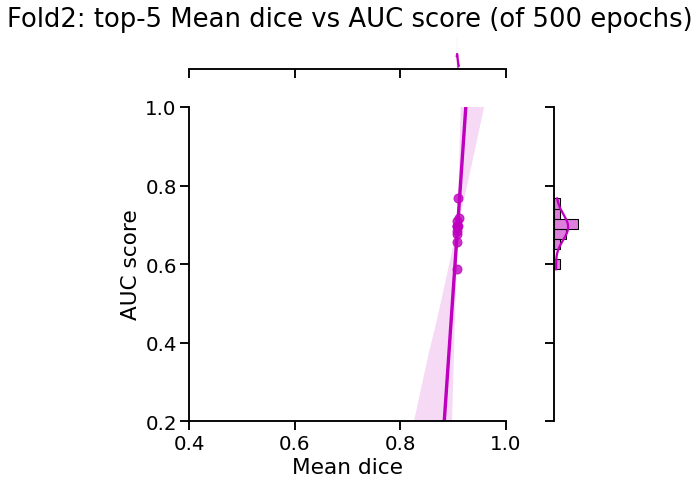

In [127]:
import seaborn as sns
sns.set_context(context='talk', font_scale=1.2)
for cfold in [0, 1, 2]:

    df_RecordsAFold = df_Records.loc[df_Records['Fold']==cfold]
    #df_RecordsAFold = df_RecordsAFold.loc[(df_RecordsAFold['Training loss']<0.8) & (df_RecordsAFold['Validation loss']<0.8)]
    df_RecordsAFold = df_RecordsAFold.nlargest(n=10, columns=['Mean dice','AUC score'])
    
    # g = sns.lmplot(x="Mean dice", y="AUC score", data=df_RecordsAFold)
    g = sns.jointplot(x="Mean dice", y="AUC score", data=df_RecordsAFold,
                  kind="reg", truncate=False,
                  xlim=(0.4, 1.0), ylim=(0.2, 1.0),
                  color="m", height=7)
    g.fig.tight_layout()
    g.fig.suptitle(f'Fold{cfold}: top-5 Mean dice vs AUC score (of 500 epochs)')
    g.fig.subplots_adjust(top=0.92) # Reduce plot to make room 